Connected to py39 (Python 3.9.0)

In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pickle
import gc
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gaussian_kde
from scipy.stats import spearmanr

In [2]:
#读取所有的测试数据
all_files_mse = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd_valid/'))]
all_files_wmse1 = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd_valid/'))]

all_files_profile = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/'))]
all_files_rank = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/'))]

In [3]:
def get_predict_data(path):
    # 读取预测数据
    # path: 预测数据的路径
    # return: 预测数据的dataframe
    data = pd.read_csv(path)
    data['Y_rank'] = data['Y'].rank(method='min')
    data['Y_hat_rank'] = data['Y_hat'].rank(method='min')
    return data


def draw_pdf(pred,label):
    vector1 = pred
    vector2 = label

    #vector1 = (vector1 - vector1.min()) / (vector1.max() - vector1.min())
    #vector2 = (vector2 - vector2.min()) / (vector2.max() - vector2.min())


    # 计算每个向量的PDF
    kde1 = gaussian_kde(vector1)
    kde2 = gaussian_kde(vector2)

    # 设置绘图的点
    x_min = min(vector1.min(), vector2.min())
    x_max = max(vector1.max(), vector2.max())
    x = np.linspace(x_min, x_max, 1000)

    # 绘制两个向量的PDF
    plt.figure(figsize=(8, 6))
    plt.plot(x, kde1(x), label='pred PDF')
    plt.plot(x, kde2(x), label='label PDF')

    # 添加图例
    plt.legend()

    # 显示图
    plt.show()


#绘制Y和Y_hat的散点图
def draw_scatter(pred,label):
    # 假设你有两个向量
    vector1 = pred
    vector2 = label

    #vector1 = (vector1 - vector1.min()) / (vector1.max() - vector1.min())
    #vector2 = (vector2 - vector2.min()) / (vector2.max() - vector2.min())

    # 创建一个带有2个子图的图形，它们并排排列
    fig, axs = plt.subplots(1, 2, figsize=(12, 6))

    # 在第一个子图中绘制vector1
    axs[0].scatter(range(len(vector1)), vector1, color='b', label='pred')
    axs[0].set_title('pred')
    axs[0].set_xlabel('code')
    axs[0].set_ylabel('Y_hat')
    axs[0].legend()

    # 在第二个子图中绘制vector2
    axs[1].scatter(range(len(vector2)), vector2, color='r', label='label')
    axs[1].set_title('label')
    axs[1].set_xlabel('code')
    axs[1].set_ylabel('Y')
    axs[1].legend()

    # 显示图形
    plt.show()

def quantile_ic(df,rank_ic_per_quantile,object = 'Y'):
    # 计算真实回报率的分位数
    quantile_labels = range(1, 6)
    df['quantile'] = pd.qcut(df['Y'], 5, labels=quantile_labels)

    for quantile in quantile_labels:
        # 选取当前分位数组内的数据
        subset = df[df['quantile'] == quantile]
        
        # 计算真实值和预测值的秩次
        true_ranks = subset['Y'].rank()
        predicted_ranks = subset['Y_hat'].rank()
        
        # 计算秩次的相关系数（Rank IC）
        rank_ic = spearmanr(true_ranks, predicted_ranks).correlation
        rank_ic_per_quantile[quantile].append(rank_ic)

    return rank_ic_per_quantile

#获取截面return的quantile，截取特定的quantile的股票
def get_specific_quantile(df,quantile_num,quantile):
    quantile_labels = range(1, quantile_num+1)
    df['quantile'] = pd.qcut(df['Y_hat'], quantile_num, labels=quantile_labels)
    subset = df[df['quantile'] == quantile]
    return subset

#画出每个quantile的rank_ic
def draw_quantile(all_files,object = 'Y'):
    rank_ic_per_quantile = {i: [] for i in range(1, 6)}
    for file in all_files:
        rank_ic_per_quantile = quantile_ic(file,rank_ic_per_quantile)


    #把rank_ic_per_quantile中每个quantile的向量按照向量值为y，向量index为x画在同一张图上
    for quantile in rank_ic_per_quantile:
        y = rank_ic_per_quantile[quantile]
        #平滑y，取5天均值，y为list
        y = pd.Series(y).rolling(5).mean().to_list()
        x = range(len(y))
        plt.plot(x,y
                ,label=f'quantile{quantile}')
        #规定label
        plt.xlabel('date')
        plt.ylabel('rank_ic')
        plt.title('rank_ic_per_quantile')
        plt.legend()

    plt.show()  

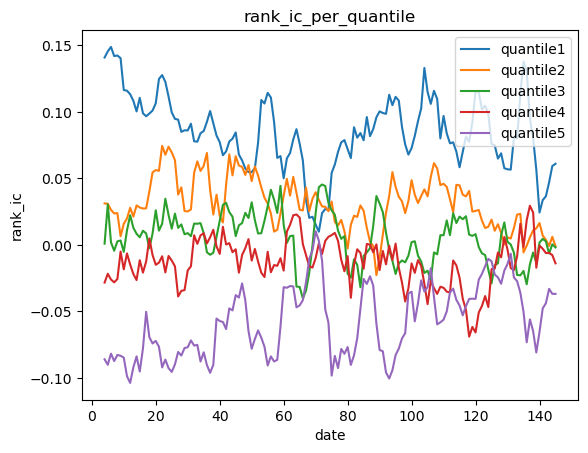

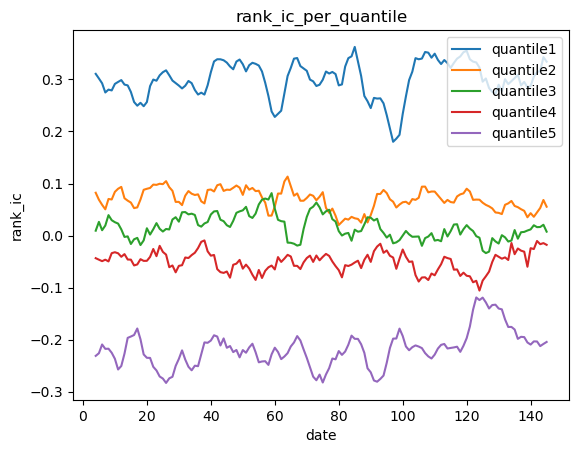

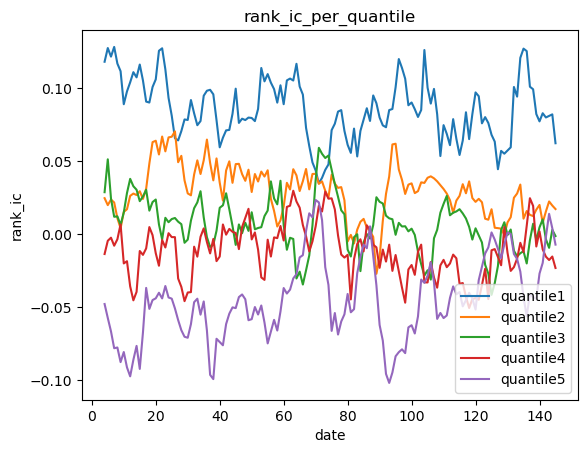

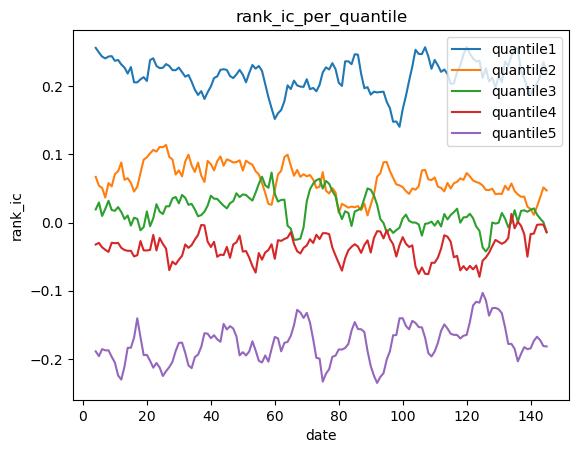

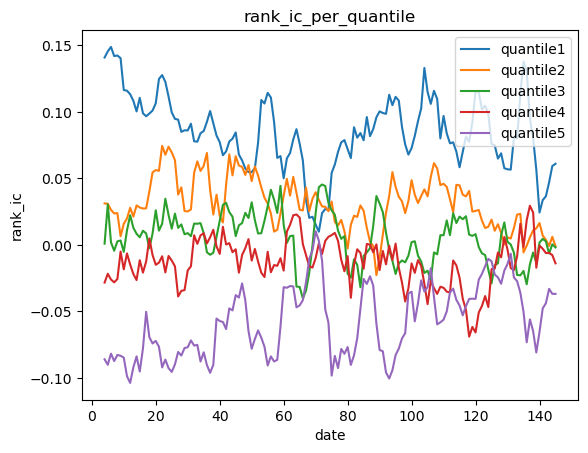

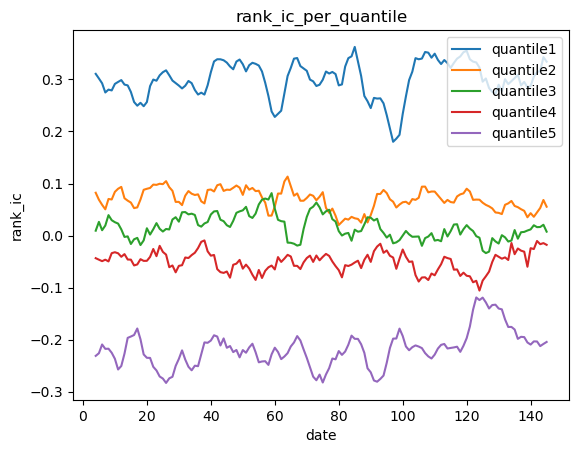

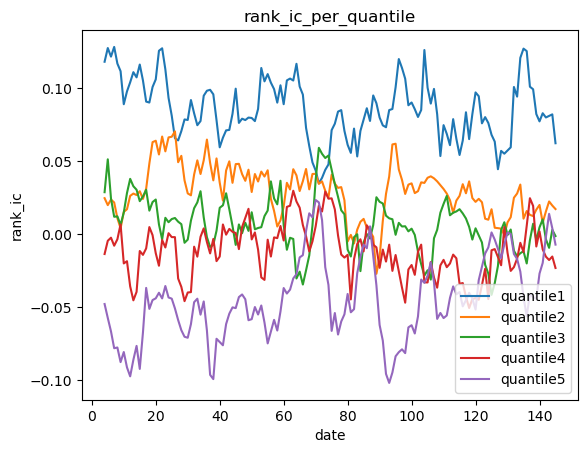

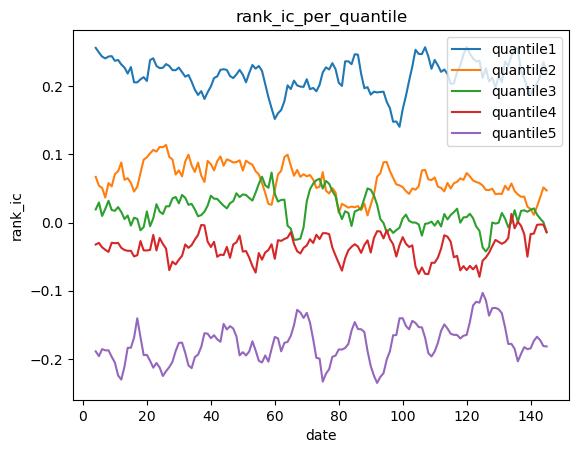

In [4]:
draw_quantile(all_files_mse,object = 'Y')
draw_quantile(all_files_wmse1,object = 'Y')
draw_quantile(all_files_profile,object = 'Y')
draw_quantile(all_files_rank,object = 'Y')

draw_quantile(all_files_mse,object = 'Y_hat')
draw_quantile(all_files_wmse1,object = 'Y_hat')
draw_quantile(all_files_profile,object = 'Y_hat')
draw_quantile(all_files_rank,object = 'Y_hat')

In [8]:
for file in all_files_mse:
    df =file
    y_hat_ratio.append(quantile_y_hat_true_ratio)
    df['quantile_y'] = pd.qcut(df['Y'], 5, labels=range(1, 5+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], 5, labels=range(1, 5+1))

In [9]:
for file in all_files_mse:
    df =file
    y_hat_ratio.append(quantile_y_hat_true_ratio)
    df['quantile_y'] = pd.qcut(df['Y'], 5, labels=range(1, 5+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], 5, labels=range(1, 5+1))
    subset = df[df['quantile_y_hat']==5]
    value_proportions = subset['quantile_y'].value_counts(normalize=True)

In [11]:
for file in all_files_mse:
    df =file
    y_hat_ratio.append(quantile_y_hat_true_ratio)
    df['quantile_y'] = pd.qcut(df['Y'], 5, labels=range(1, 5+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], 5, labels=range(1, 5+1))
    subset = df[df['quantile_y_hat']==5]
    value_proportions = subset['quantile_y'].value_counts(normalize=True)

    quantile_labels = range(1, 6)

    for quantile in quantile_labels:
        # 选取当前分位数组内的数据
        tmp = subset[subset['quantile_y'] == quantile]
        
        # 计算真实值和预测值的秩次
        true_ranks =tmp['Y'].rank()
        predicted_ranks = tmp['Y_hat'].rank()
        
        # 计算秩次的相关系数（Rank IC）
        rank_ic = spearmanr(true_ranks, predicted_ranks).correlation
        print(quantile,rank_ic)
    break

1 0.008363424577751891
2 0.013896205248268461
3 0.007837704991286474
4 -0.11641937239252675
5 -0.10970873786407769


In [13]:
for file in all_files_wmse1:
    df =file
    y_hat_ratio.append(quantile_y_hat_true_ratio)
    df['quantile_y'] = pd.qcut(df['Y'], 5, labels=range(1, 5+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], 5, labels=range(1, 5+1))
    subset = df[df['quantile_y_hat']==5]
    value_proportions = subset['quantile_y'].value_counts(normalize=True)

    quantile_labels = range(1, 6)

    for quantile in quantile_labels:
        # 选取当前分位数组内的数据
        tmp = subset[subset['quantile_y'] == quantile]
        
        # 计算真实值和预测值的秩次
        true_ranks =tmp['Y'].rank()
        predicted_ranks = tmp['Y_hat'].rank()
        
        # 计算秩次的相关系数（Rank IC）
        rank_ic = spearmanr(true_ranks, predicted_ranks).correlation
        print(quantile,rank_ic)
    break

1 -0.010782361308677097
2 -0.08244469441319835
3 0.008056863355744043
4 -0.02035553099382886
5 -0.15743514797223238


In [15]:
for file in all_files_wmse1:
    df =file
    y_hat_ratio.append(quantile_y_hat_true_ratio)
    df['quantile_y'] = pd.qcut(df['Y'], 5, labels=range(1, 5+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], 5, labels=range(1, 5+1))
    subset = df[df['quantile_y_hat']==1]
    value_proportions = subset['quantile_y'].value_counts(normalize=True)

    quantile_labels = range(1, 6)

    for quantile in quantile_labels:
        # 选取当前分位数组内的数据
        tmp = subset[subset['quantile_y'] == quantile]
        
        # 计算真实值和预测值的秩次
        true_ranks =tmp['Y'].rank()
        predicted_ranks = tmp['Y_hat'].rank()
        
        # 计算秩次的相关系数（Rank IC）
        rank_ic = spearmanr(true_ranks, predicted_ranks).correlation
        print(quantile,rank_ic)
    break

1 0.3479777708283724
2 -0.10171234492193026
3 0.04240153892882455
4 -0.11959501172984317
5 -0.1375257126065237


In [16]:
for file in all_files_mse:
    df =file
    y_hat_ratio.append(quantile_y_hat_true_ratio)
    df['quantile_y'] = pd.qcut(df['Y'], 5, labels=range(1, 5+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], 5, labels=range(1, 5+1))
    subset = df[df['quantile_y_hat']==1]
    value_proportions = subset['quantile_y'].value_counts(normalize=True)

    quantile_labels = range(1, 6)

    for quantile in quantile_labels:
        # 选取当前分位数组内的数据
        tmp = subset[subset['quantile_y'] == quantile]
        
        # 计算真实值和预测值的秩次
        true_ranks =tmp['Y'].rank()
        predicted_ranks = tmp['Y_hat'].rank()
        
        # 计算秩次的相关系数（Rank IC）
        rank_ic = spearmanr(true_ranks, predicted_ranks).correlation
        print(quantile,rank_ic)
    break

1 0.16791121399369016
2 0.0242446822923723
3 -0.06557377049180328
4 -0.0159506445355742
5 -0.03955145929339477


In [17]:
all_files_wmse1 = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse_decay)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse_decay)_depth4_sizes(249_128_128_1)_bd_valid/'))]

In [18]:
all_files_wmse2 = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse_decay)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse_decay)_depth4_sizes(249_128_128_1)_bd_valid/'))]

In [19]:
#读取所有的测试数据
all_files_mse = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd_valid/'))]
all_files_wmse1 = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd_valid/'))]

all_files_profile = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/'))]
all_files_rank = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/'))]

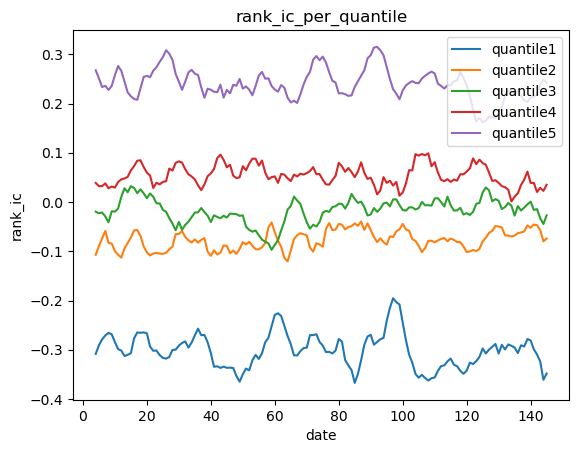

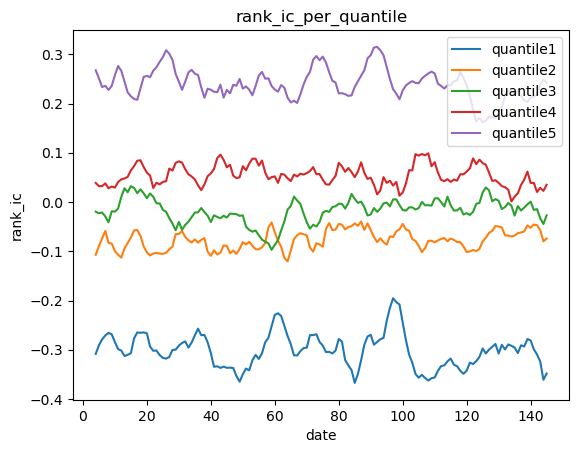

In [20]:
draw_quantile(all_files_wmse2,object = 'Y')
draw_quantile(all_files_wmse2,object = 'Y_hat')

In [21]:
for file in all_files_wmse2:
    df =file
    y_hat_ratio.append(quantile_y_hat_true_ratio)
    df['quantile_y'] = pd.qcut(df['Y'], 5, labels=range(1, 5+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], 5, labels=range(1, 5+1))
    subset = df[df['quantile_y_hat']==5]
    value_proportions = subset['quantile_y'].value_counts(normalize=True)

    quantile_labels = range(1, 6)

    for quantile in quantile_labels:
        # 选取当前分位数组内的数据
        tmp = subset[subset['quantile_y'] == quantile]
        
        # 计算真实值和预测值的秩次
        true_ranks =tmp['Y'].rank()
        predicted_ranks = tmp['Y_hat'].rank()
        
        # 计算秩次的相关系数（Rank IC）
        rank_ic = spearmanr(true_ranks, predicted_ranks).correlation
        print(quantile,rank_ic)
    break

1 -0.2860149333806993
2 0.19615648592999316
3 -0.09635846372688477
4 -0.006341201396556354
5 0.23053881626379003


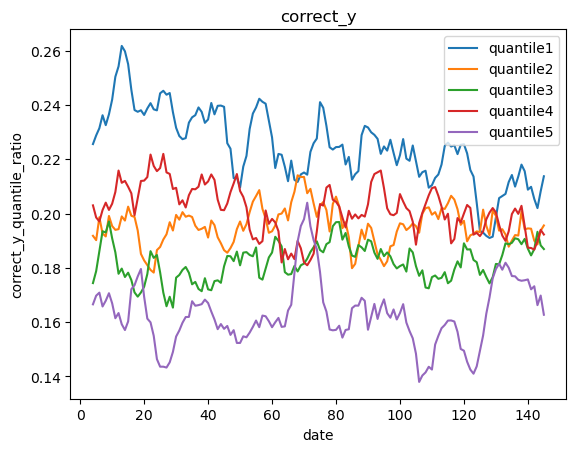

In [23]:
def get_qantile_ratio(df,quantile,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y也为quantile的比例
    quantile_y_true = subset[subset['quantile_y'] == quantile]
    quantile_y_true_ratio = len(quantile_y_true)/len(subset)       

    return quantile_y_true_ratio

quantile_ratio_dict = {i: [] for i in range(1, 6)}
for file in all_files_mse:
    for q in range(1,6):
        quantile_y_true_ratio = get_qantile_ratio(file,quantile=q)
        quantile_ratio_dict[q].append(quantile_y_true_ratio)

#把rank_ic_per_quantile中每个quantile的向量按照向量值为y，向量index为x画在同一张图上
for quantile in quantile_ratio_dict:
    y = quantile_ratio_dict[quantile]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y
            ,label=f'quantile{quantile}')
    #规定label
    plt.xlabel('date')
    plt.ylabel('correct_y_quantile_ratio')
    plt.title('correct_y')
    plt.legend()

plt.show()  

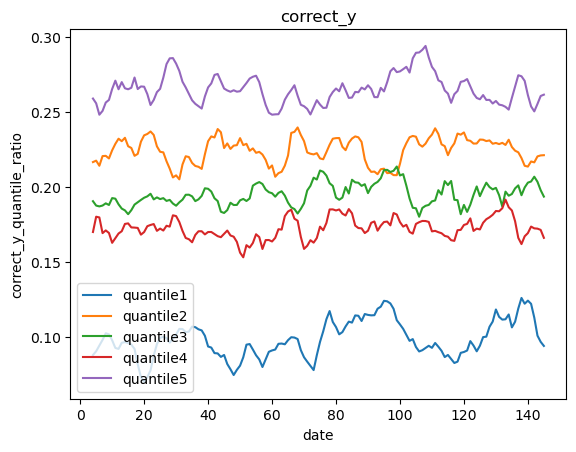

In [24]:
def get_qantile_ratio(df,quantile,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y也为quantile的比例
    quantile_y_true = subset[subset['quantile_y'] == quantile]
    quantile_y_true_ratio = len(quantile_y_true)/len(subset)       

    return quantile_y_true_ratio

quantile_ratio_dict = {i: [] for i in range(1, 6)}
for file in all_files_wmse2:
    for q in range(1,6):
        quantile_y_true_ratio = get_qantile_ratio(file,quantile=q)
        quantile_ratio_dict[q].append(quantile_y_true_ratio)

#把rank_ic_per_quantile中每个quantile的向量按照向量值为y，向量index为x画在同一张图上
for quantile in quantile_ratio_dict:
    y = quantile_ratio_dict[quantile]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y
            ,label=f'quantile{quantile}')
    #规定label
    plt.xlabel('date')
    plt.ylabel('correct_y_quantile_ratio')
    plt.title('correct_y')
    plt.legend()

plt.show()  

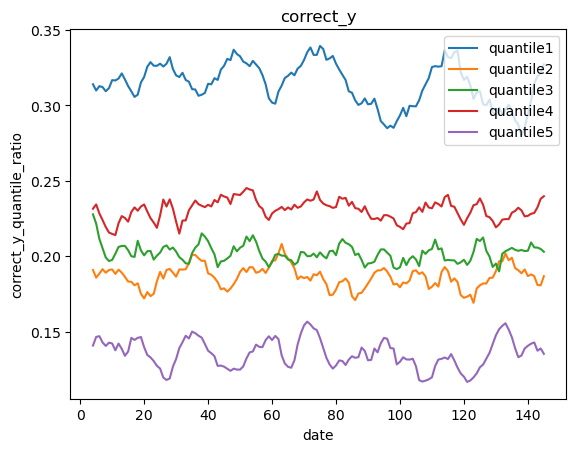

In [25]:
def get_qantile_ratio(df,quantile,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y也为quantile的比例
    quantile_y_true = subset[subset['quantile_y'] == quantile]
    quantile_y_true_ratio = len(quantile_y_true)/len(subset)       

    return quantile_y_true_ratio

quantile_ratio_dict = {i: [] for i in range(1, 6)}
for file in all_files_wmse1:
    for q in range(1,6):
        quantile_y_true_ratio = get_qantile_ratio(file,quantile=q)
        quantile_ratio_dict[q].append(quantile_y_true_ratio)

#把rank_ic_per_quantile中每个quantile的向量按照向量值为y，向量index为x画在同一张图上
for quantile in quantile_ratio_dict:
    y = quantile_ratio_dict[quantile]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y
            ,label=f'quantile{quantile}')
    #规定label
    plt.xlabel('date')
    plt.ylabel('correct_y_quantile_ratio')
    plt.title('correct_y')
    plt.legend()

plt.show()  

In [26]:
#读入测试集数据
all_files_mse = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd/'))]
all_files_wmse1 = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd/'))]

all_files_profile = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd/'))]
all_files_rank = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd/'))]

all_files_wmse2 = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse_decay)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse_decay)_depth4_sizes(249_128_128_1)_bd/'))]

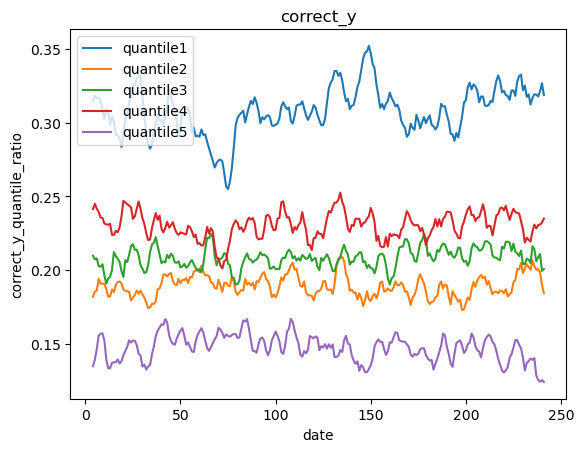

In [27]:
def get_qantile_ratio(df,quantile,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y也为quantile的比例
    quantile_y_true = subset[subset['quantile_y'] == quantile]
    quantile_y_true_ratio = len(quantile_y_true)/len(subset)       

    return quantile_y_true_ratio

quantile_ratio_dict = {i: [] for i in range(1, 6)}
for file in all_files_wmse1:
    for q in range(1,6):
        quantile_y_true_ratio = get_qantile_ratio(file,quantile=q)
        quantile_ratio_dict[q].append(quantile_y_true_ratio)

#把rank_ic_per_quantile中每个quantile的向量按照向量值为y，向量index为x画在同一张图上
for quantile in quantile_ratio_dict:
    y = quantile_ratio_dict[quantile]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y
            ,label=f'quantile{quantile}')
    #规定label
    plt.xlabel('date')
    plt.ylabel('correct_y_quantile_ratio')
    plt.title('correct_y')
    plt.legend()

plt.show()  

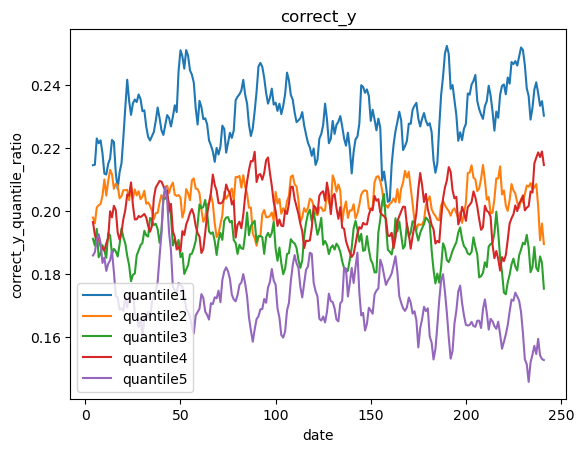

In [28]:
def get_qantile_ratio(df,quantile,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y也为quantile的比例
    quantile_y_true = subset[subset['quantile_y'] == quantile]
    quantile_y_true_ratio = len(quantile_y_true)/len(subset)       

    return quantile_y_true_ratio

quantile_ratio_dict = {i: [] for i in range(1, 6)}
for file in all_files_mse:
    for q in range(1,6):
        quantile_y_true_ratio = get_qantile_ratio(file,quantile=q)
        quantile_ratio_dict[q].append(quantile_y_true_ratio)

#把rank_ic_per_quantile中每个quantile的向量按照向量值为y，向量index为x画在同一张图上
for quantile in quantile_ratio_dict:
    y = quantile_ratio_dict[quantile]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y
            ,label=f'quantile{quantile}')
    #规定label
    plt.xlabel('date')
    plt.ylabel('correct_y_quantile_ratio')
    plt.title('correct_y')
    plt.legend()

plt.show()  

In [31]:
def get_qantile_ratio(df,quantile,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y也为quantile的比例
    quantile_y_true = subset[subset['quantile_y'] == quantile]
    quantile_y_true_ratio = len(quantile_y_true)/len(subset)       

    return quantile_y_true_ratio

def get_mistake_quantile_ratio(df,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y为中位数以后的quantiel的比例
    quantile_y_mistake = subset[subset['quantile_y'] <= quantile_num//2]
    quantile_y_mistake_ratio = len(quantile_y_mistake)/len(subset)
    return quantile_y_mistake_ratio

In [35]:
#读取验证集数据
all_files_mse = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd_valid/'))]
all_files_wmse1 = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd_valid/'))]

all_files_profile = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/'))]
all_files_rank = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/'))]

In [36]:
#读取验证集数据
all_files_mse = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd_valid/'))]
all_files_wmse1 = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd_valid/'))]

all_files_profile = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/'))]
all_files_rank = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/'))]

all_files_wmse2 = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse_decay)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse_decay)_depth4_sizes(249_128_128_1)_bd_valid/'))]

In [37]:
#读入测试集数据
all_files_mse_test = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(advance)_depth4_sizes(249_128_128_1)_bd/'))]
all_files_wmse1_test = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse)_depth4_sizes(249_128_128_1)_bd/'))]

all_files_profile_test = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_profile_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd/'))]
all_files_rank_test = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd/'))]

all_files_wmse2_test = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse_decay)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label__all_normal_no_ud_limit_h2/selected_feature(all)_loss(wmse_decay)_depth4_sizes(249_128_128_1)_bd/'))]

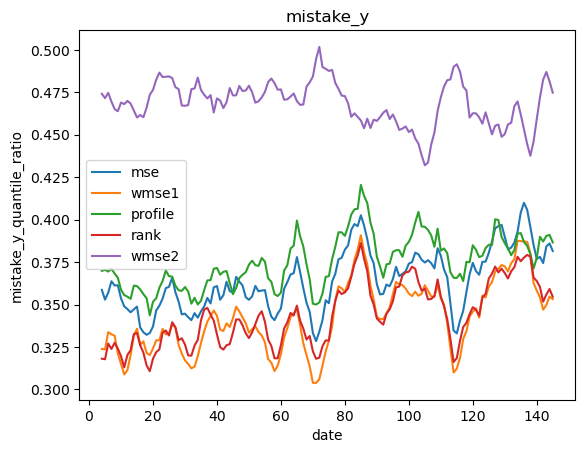

In [39]:
all_file = {'mse':all_files_mse,'wmse1':all_files_wmse1,'profile':all_files_profile,'rank':all_files_rank,'wmse2':all_files_wmse2}
all_file_test = {'mse':all_files_mse_test,'wmse1':all_files_wmse1_test,'profile':all_files_profile_test,'rank':all_files_rank_test,'wmse2':all_files_wmse2_test}
mistake_quatile_ratio = dict()
#获取quantile5中mistake quantile的比例
for name,all_files in all_file.items():
    mistake_quatile_ratio[name] = []
    for file in all_files:
        mistake_quatile_ratio[name].append( get_mistake_quantile_ratio(file))

    y = mistake_quatile_ratio[name]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y,label=name)
    #规定label
    plt.xlabel('date')
    plt.ylabel('mistake_y_quantile_ratio')
    plt.title('mistake_y')
    plt.legend()

plt.show()  

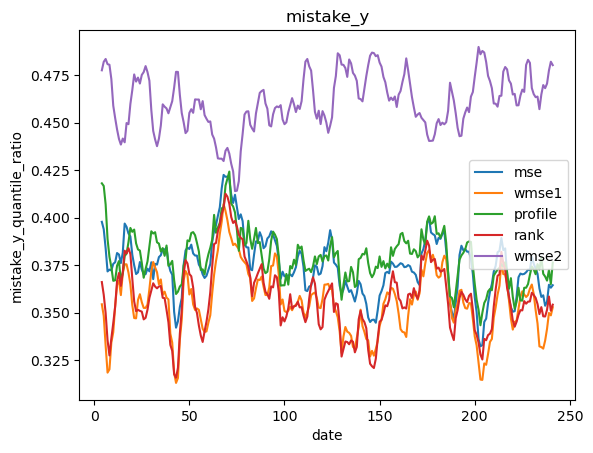

In [40]:
all_file = {'mse':all_files_mse,'wmse1':all_files_wmse1,'profile':all_files_profile,'rank':all_files_rank,'wmse2':all_files_wmse2}
all_file_test = {'mse':all_files_mse_test,'wmse1':all_files_wmse1_test,'profile':all_files_profile_test,'rank':all_files_rank_test,'wmse2':all_files_wmse2_test}
mistake_quatile_ratio = dict()
#获取quantile5中mistake quantile的比例
for name,all_files in all_file_test.items():
    mistake_quatile_ratio[name] = []
    for file in all_files:
        mistake_quatile_ratio[name].append( get_mistake_quantile_ratio(file))

    y = mistake_quatile_ratio[name]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y,label=name)
    #规定label
    plt.xlabel('date')
    plt.ylabel('mistake_y_quantile_ratio')
    plt.title('mistake_y')
    plt.legend()

plt.show()  

In [41]:
def get_qantile_ratio(df,quantile,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y也为quantile的比例
    quantile_y_true = subset[subset['quantile_y'] == quantile]
    quantile_y_true_ratio = len(quantile_y_true)/len(subset)       

    return quantile_y_true_ratio

def get_mistake_quantile_ratio(df,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y为中位数以后的quantiel的比例
    quantile_y_mistake = subset[subset['quantile_y'] <= quantile_num//2]
    quantile_y_mistake_ratio = len(quantile_y_mistake)/len(subset)
    return quantile_y_mistake_ratio

def get_negative_return_ratio(df,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中Y为负的比例
    quantile_y_mistake = subset[subset['Y'] <= 0]
    quantile_y_mistake_ratio = len(quantile_y_mistake)/len(subset)
    return quantile_y_mistake_ratio

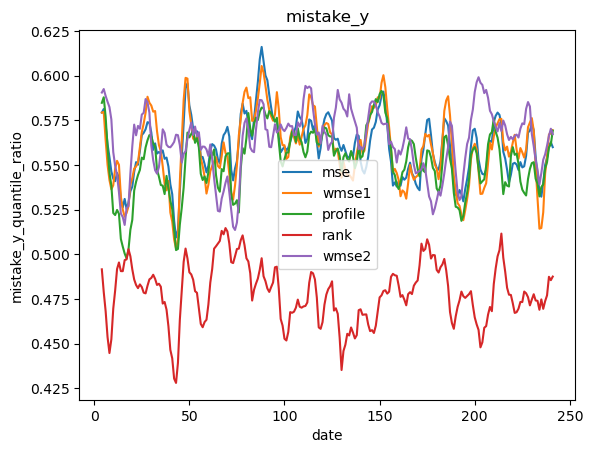

In [42]:
all_file = {'mse':all_files_mse,'wmse1':all_files_wmse1,'profile':all_files_profile,'rank':all_files_rank,'wmse2':all_files_wmse2}
all_file_test = {'mse':all_files_mse_test,'wmse1':all_files_wmse1_test,'profile':all_files_profile_test,'rank':all_files_rank_test,'wmse2':all_files_wmse2_test}
mistake_quatile_ratio = dict()
#获取quantile5中mistake quantile的比例
for name,all_files in all_file_test.items():
    mistake_quatile_ratio[name] = []
    for file in all_files:
        mistake_quatile_ratio[name].append( get_negative_return_ratio(file))

    y = mistake_quatile_ratio[name]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y,label=name)
    #规定label
    plt.xlabel('date')
    plt.ylabel('mistake_y_quantile_ratio')
    plt.title('mistake_y')
    plt.legend()

plt.show()  

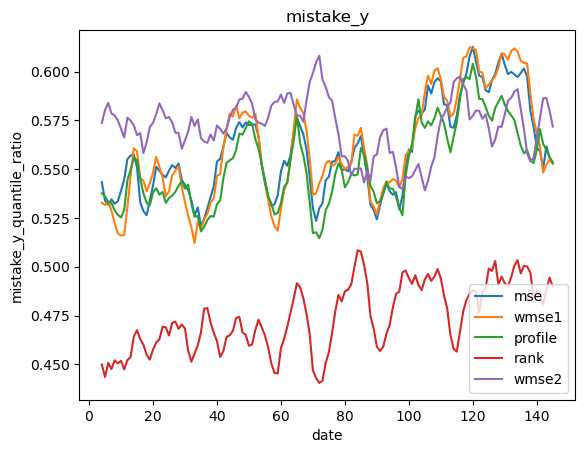

In [43]:
all_file = {'mse':all_files_mse,'wmse1':all_files_wmse1,'profile':all_files_profile,'rank':all_files_rank,'wmse2':all_files_wmse2}
all_file_test = {'mse':all_files_mse_test,'wmse1':all_files_wmse1_test,'profile':all_files_profile_test,'rank':all_files_rank_test,'wmse2':all_files_wmse2_test}
mistake_quatile_ratio = dict()
#获取quantile5中mistake quantile的比例
for name,all_files in all_file.items():
    mistake_quatile_ratio[name] = []
    for file in all_files:
        mistake_quatile_ratio[name].append( get_negative_return_ratio(file))

    y = mistake_quatile_ratio[name]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y,label=name)
    #规定label
    plt.xlabel('date')
    plt.ylabel('mistake_y_quantile_ratio')
    plt.title('mistake_y')
    plt.legend()

plt.show()  

In [44]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pickle
import gc
import scipy.stats as st

def trim(x, rlow=None, rhigh=None,ratio=None,drop_nan=True): # 0<ratio<0.5
    x1 = x.copy()
    if ratio != None:
        if drop_nan:
            x2 = x1.loc[x1.notna()]
            rlow = np.percentile(x2.values,ratio*100)
            rhigh = np.percentile(x2.values, (1-ratio)*100)
        else:
            print('[ERROR] nan in x values!')
            raise BaseException
    x1[x1<rlow] = rlow
    x1[x1>rhigh] = rhigh
    return x1

def cal_norm(ds):
    ds1 = ds.rank(pct=False,ascending=True,na_option='keep')/(ds.notna().sum()+1)
    ds2 = pd.Series(st.norm().ppf(ds1),index=ds.index)
    return ds2

def calTurnover(flagMat,isSummary=True):
## flag.mat contains 1, -1, NA;
## turnover=1 means we trade 1 (buy 0.5 and sell 0.5) every day;
    flagMat = flagMat.fillna(0)
    posiNum = (flagMat!=0).sum(axis=1)
    
    tradeMat = (flagMat - flagMat.shift(1,axis=0)).abs()
    to = (tradeMat.sum(axis=1)/(posiNum+posiNum.shift(1))*2).fillna(0)
    if isSummary:
        to = '%.3g'%to.mean()
    return to

def draw_pnl(rtn_vec,fig_name = 'backtest'):
    alpha = rtn_vec.mean()*1e4
    sigma = rtn_vec.std()*1e4
    sharpe = alpha/sigma *np.sqrt(252)
    win_rate = (rtn_vec>0).sum()/(rtn_vec.notna().sum())

    dd = (rtn_vec.cumsum() - rtn_vec.cumsum().cummax())
    mdd = dd.min()*1e2
    mdd_date = dd.idxmin()
    
    fig_name = '{0}:alpha={1};sigma={2};sharpe={3};win_rate={4};mdd={5}% on {6}'.format(
            fig_name,'%.2f'%alpha,'%.2f'%sigma,'%.2f'%sharpe,'%.2f'%win_rate,
            '%.2f'%mdd,mdd_date)

    rtn_vec.cumsum().plot(title=fig_name)
    res = pd.Series([alpha,sigma,sharpe,win_rate,mdd,mdd_date],
                        index=['alpha','sigma','sharpe','win_rate','mdd','mdd_date'])
    return res

def plotPNL(rtnMat,posiMat,posiMat_nature='position',costbps=10,figName='backtest',savefigFile=None):
    '''
    posiMat:contains[0,1],no np.nan;
    '''
    ## 1) calculate pnlVec, costVec;
    pnlMat = rtnMat * posiMat
    if posiMat_nature=='position':
        pnlVec = pnlMat.sum(axis=1)/(posiMat==1).sum(axis=1)
        turnoverVec = calTurnover(posiMat,isSummary=False)
    elif posiMat_nature=='weight':
        pnlVec = pnlMat.sum(axis=1)
        turnoverVec = abs( posiMat.fillna(0) - posiMat.fillna(0).shift(1,axis=0)).sum(axis=1)
    else:
        print('[ERROR] wrong posiMat_nature value!')
        return False

    costVec = turnoverVec * costbps * 1e-4
    pnl_afterCostVec = pnlVec - costVec
    
    ## 2) calculate indicators & pnl(DataFrame);
    alpha = pnlVec.mean()*1e4
    alpha2 = pnl_afterCostVec.mean()*1e4
    sigma = pnlVec.std()*1e4
    sharpe = alpha/sigma*np.sqrt(252)
    sharpe2 = pnl_afterCostVec.mean()/pnl_afterCostVec.std()*np.sqrt(252)
    stkNum = posiMat.fillna(0).apply(lambda x: (x!=0).sum(),axis=1).mean()
    turnover = turnoverVec.mean()
    win_rate = (pnl_afterCostVec>0).sum()/(pnl_afterCostVec.notna().sum())

    pnl = pd.DataFrame(pnlVec,columns=['pnl'])
    pnl['cum_pnl'] = pnlVec.cumsum()
    pnl['cost'] = costVec
    pnl['cum_cost'] = costVec.cumsum()
    pnl['pnl_afterCost'] = pnl_afterCostVec
    pnl['cum_pnl_afterCost'] = pnl_afterCostVec.cumsum()
    pnl['drawdown'] = pnl['cum_pnl'] - pnl['cum_pnl'].cummax()
    pnl.reset_index(inplace=True)
    pnl['date'] = pd.to_datetime(pnl['date'])
    pnl.set_index('date',inplace=True)
    
    mdd = pnl['drawdown'].min()*1e2
    mdd_date = pnl['drawdown'].idxmin()

    ## 3) plot PNL: pd.Series.plot() + pd.Series.plot.bar()
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_axes([0,0.4,1,1]) ## 第1个子图；
    pnl['cum_pnl'].plot(color='blue') ##pd.Series.plot()能够自动识别日期类index，并作为xlable;（并且会自动选择合适的采样）
    pnl['cum_pnl_afterCost'].plot(color='red')
    pnl['cum_cost'].plot(color='green')
    ax2 = fig.add_axes([0,0,1,0.25]) ## 第2个子图；
    pnl['drawdown'].plot.bar(color='gray') ##绘制plot.bar时，xlable并不会自动选择合适的采样；

    ax1.grid(True,axis='x',color='green',linestyle=':',linewidth=0.5) ## 绘制辅助线；
    ax2.grid(True,axis='x',color='green',linestyle=':',linewidth=0.5)

    ax2.xaxis.set_visible(False) ##xlable太密集，不显示
    ax1.set_xlabel('')
    thisName = '{0}:alpha={1};sigma={2};sharpe={3};stknum={4};turnover={5};win_rate={6};mdd={7}% on {8}'.format(
        figName,'%.2f'%alpha,'%.2f'%sigma,'%.2f'%sharpe,'%.2f'%stkNum,'%.2f'%turnover,'%.2f'%win_rate,
        '%.2f'%mdd,mdd_date.strftime('%Y%m%d'))
    ax1.set_title(thisName)
    ax1.legend(loc='upper left',labels=['pnl','pnl_afterCost','cost'])
    if savefigFile != None:
        fig.savefig(savefigFile,dpi=100,bbox_inches='tight')
    res = pd.Series([alpha,sigma,sharpe,alpha2,sharpe2,stkNum,turnover,win_rate,mdd,mdd_date.strftime('%Y%m%d')],
                    index=['alpha','sigma','sharpe','alpha2','sharpe2','stkNum','turnover','win_rate','mdd','mdd_date'])
#     plt.clf()
#     plt.close(fig)
    return {'pnl':pnl,'pnl_summary':res}

def cal_topPNL(yestData,enterRatio=0.8,exitRatio=0.8,year='all',costbps=10,savefigFile=None):    
    if (not all([x in yestData.columns for x in ['date','code','yest','y']])):
        print("[ERROR] yestData's format is wrong!")
        return False
    d1 = yestData.loc[:,['date','code','yest','y']]
    
    #pdb.set_trace()
    ## 1) calculate yestRank & posi;
    d1['yestRank'] = d1.groupby('date')['yest'].rank(method='average',na_option='keep',ascending=True,pct=True)
    
    ## 2) rtnMat & posiMat;
    rtnMat = pd.pivot_table(data=d1,index='date',columns='code',values='y',dropna=False)
    yestRankMat = pd.pivot_table(data=d1,index='date',columns='code',values='yestRank',dropna=False)
    posiMat = pd.DataFrame(np.full(yestRankMat.shape,fill_value=np.nan),index=yestRankMat.index,columns=yestRankMat.columns)
    posiMat[yestRankMat>enterRatio] = 1
    posiMat[yestRankMat<exitRatio] = 0
    posiMat = posiMat.fillna(method='ffill',axis=0).fillna(0)
    posiMat[yestRankMat.isna()] = np.nan
    
    ## 3) result
    if (year=='all'):
        res = plotPNL(rtnMat,posiMat,costbps=costbps,figName=year,savefigFile=savefigFile)
        res['pnl_summary'] = res['pnl_summary'].to_frame(name='all').T
    elif(year=='each'):
        all_year = rtnMat.index.str.slice(0,4).unique()
        pnl_list = []
        pnl_sum_dict = {}
        for tmp_year in all_year:
            tmp_posiMat = posiMat.loc[posiMat.index.str.slice(0,4)==tmp_year,:]
            tmp_rtnMat = rtnMat.loc[rtnMat.index.str.slice(0,4)==tmp_year,:]
            tmp = plotPNL(tmp_rtnMat,tmp_posiMat,costbps=costbps,figName=tmp_year,savefigFile=savefigFile)
            pnl_list.append(tmp['pnl'])
            pnl_sum_dict[tmp_year] = tmp['pnl_summary']
        res = {}
        res['pnl'] = pd.concat(pnl_list,axis=0)
        res['pnl_summary'] = pd.DataFrame(pnl_sum_dict).T
    else:
        tmp_posiMat = posiMat.loc[posiMat.index.str.slice(0,4)==year,:]
        tmp_rtnMat = rtnMat.loc[rtnMat.index.str.slice(0,4)==year,:]
        res = plotPNL(tmp_rtnMat,tmp_posiMat,costbps=costbps,figName=year,savefigFile=savefigFile)
        res['pnl_summary'] = res['pnl_summary'].to_frame(name='all').T
    return(res)

def cal_topPNL2(yestData,ud_field='ud_limit',enterRatio=0.8,exitRatio=0.8,year='all',costbps=10,savefigFile=None):
    ## no buy if up_limit && no sell if down_limit;
    if (not all([x in yestData.columns for x in ['date','code','yest','y']])):
        print("[ERROR] yestData's format is wrong!")
        return False
    d1 = yestData.copy()

    ## 1) calculate yestRank;
    d1['yestRank'] = d1.groupby('date')['yest'].rank(method='average',na_option='keep',ascending=True,pct=True)
    rtnMat = pd.pivot_table(data=d1,index='date',columns='code',values='y',dropna=False)
    yestMat = pd.pivot_table(data=d1,index='date',columns='code',values='yest',dropna=False)
    yestRankMat = pd.pivot_table(data=d1,index='date',columns='code',values='yestRank',dropna=False).fillna(0)
    posiMat = pd.DataFrame(np.full(yestRankMat.shape,fill_value=0),index=yestRankMat.index,columns=yestRankMat.columns)
    ud_limitMat = pd.pivot_table(data=d1,index='date',columns='code',values=ud_field,dropna=False).fillna(0)

    ## 2) calPosiMat： ## no buy if up_limit && no sell if down_limit;
    for i,row_index in enumerate(posiMat.index):
        if (i==0):
            continue
        flag1 = (yestRankMat.iloc[i,:]>enterRatio)
        flag2 = (posiMat.iloc[i-1,:]==0) & (ud_limitMat.iloc[i,:]==1)
        posiMat.loc[row_index,(~flag2 & flag1)] = 1

        flag3 = (yestRankMat.iloc[i,:]>exitRatio) & (yestRankMat.iloc[i,:]<=enterRatio)
        flag4 = (posiMat.iloc[i-1,:]==1)
        posiMat.loc[row_index,(flag3 & flag4)] = 1

        flag5 = (posiMat.iloc[i-1,:]==1) & (posiMat.iloc[i,:]==0) & (ud_limitMat.iloc[i,:]==-1)
        posiMat.loc[row_index,flag5] = 1
        
        if (i== (posiMat.shape[0]-1)):## position=0 if yest=NA on last day;
            flag6 = yestMat.iloc[i,:].isna()
            posiMat.loc[row_index,flag6] = 0
        
    #pdb.set_trace()
    ## 3) result
    if (year=='all'):
        res = plotPNL(rtnMat,posiMat,costbps=costbps,figName=year,savefigFile=savefigFile)
        res['pnl_summary'] = res['pnl_summary'].to_frame(name='all').T
    elif(year=='each'):
        all_year = rtnMat.index.str.slice(0,4).unique()
        pnl_list = []
        pnl_sum_dict = {}
        for tmp_year in all_year:
            tmp_posiMat = posiMat.loc[posiMat.index.str.slice(0,4)==tmp_year,:]
            tmp_rtnMat = rtnMat.loc[rtnMat.index.str.slice(0,4)==tmp_year,:]
            tmp = plotPNL(tmp_rtnMat,tmp_posiMat,costbps=costbps,figName=tmp_year,savefigFile=savefigFile)
            pnl_list.append(tmp['pnl'])
            pnl_sum_dict[tmp_year] = tmp['pnl_summary']
        res = {}
        res['pnl'] = pd.concat(pnl_list,axis=0)
        res['pnl_summary'] = pd.DataFrame(pnl_sum_dict).T
    else:
        tmp_posiMat = posiMat.loc[posiMat.index.str.slice(0,4)==year,:]
        tmp_rtnMat = rtnMat.loc[rtnMat.index.str.slice(0,4)==year,:]
        res = plotPNL(tmp_rtnMat,tmp_posiMat,costbps=costbps,figName=year,savefigFile=savefigFile)
        res['pnl_summary'] = res['pnl_summary'].to_frame(name='all').T
    return(res)

def cal_posPNL(yestData,y_type='y5'):## calculate positive weight pnl;
    def _cal_posPNL(df):
        df['yest_norm'] = cal_norm(df['yest'])
        df['flag'] = (df['yest_norm']>0) & (df['ud_limit_h2']!=1)
        res = (df[y_type] * df['yest_norm'] * df['flag']).sum()/(df['yest_norm'] * df['flag']).sum()
        return res
    
    pnl = yestData.groupby('date').apply(_cal_posPNL)
    alpha = pnl.mean()*1e4
    sigma = pnl.std()*1e4
    sharpe = alpha/sigma*np.sqrt(252)
    pnl_summary = pd.Series([alpha,sigma,sharpe,],index=['alpha','sigma','sharpe',])
    return {'pnl':pnl,'pnl_summary':pnl_summary}

def cal_scorecard(df,y_type = 'y5',method = 'pearson'):
    ic = df.groupby('date')[['yest',y_type]].apply(lambda x:x.corr(method=method).iloc[0,1])
    ic_mean = ic.mean()
    ic_std = ic.std()
    icir = ic_mean/ic_std*pow(250,0.5)
    return {'ic':ic,'ic_mean':ic_mean,'icir':icir}

def cal_multiPNL(yestData):
    top_pnl = cal_topPNL(yestData,enterRatio=0.95,exitRatio=0.85,year='all',costbps=10,savefigFile=None)
    top_pnl2 = cal_topPNL2(yestData,ud_field='ud_limit_h2',enterRatio=0.95,exitRatio=0.85,year='all',costbps=10,savefigFile=None)  #
    pos_pnl = cal_posPNL(yestData,y_type='y5')
    ic_test = yestData[['date','y5','yest']].set_index('date')
    res_indicator = cal_scorecard(ic_test,y_type = 'y5',method = 'pearson')
    res_all = {'res_indicator':res_indicator,'top_pnl':top_pnl,'top_pnl2':top_pnl2,'pos_pnl':pos_pnl}
    return res_all

def simple_ols(yestData, yest1='yest_benchmark', yest2='yest_pool', weight1=0.4):
    yest_norm = yestData.groupby('date')[[yest1, yest2]].apply(lambda x: (x - x.mean()) / x.std())
    weight2 = 1 - weight1
    yest = weight1 * yest_norm[yest1] + weight2 * yest_norm[yest2]
    return yest
    
def cal_margin(m_old,m_new):
    s01 = m_old['top_pnl2']['pnl_summary'].loc['all',['alpha','sharpe2']]
    s02 = m_old['pos_pnl']['pnl_summary'][['alpha','sharpe']]
    m0 = s01.append(s02)
    s11 = m_new['top_pnl2']['pnl_summary'].loc['all',['alpha','sharpe2']]
    s12 = m_new['pos_pnl']['pnl_summary'][['alpha','sharpe']]
    m1 = s11.append(s12)
    margin_top = (s11/s01).sum()/2
    margin_pos = (s12/s02).sum()/2
    margin = (m1/m0).sum()/4
    return pd.Series({'margin_top':margin_top,'margin_pos':margin_pos,'margin':margin})

In [45]:
all_files = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd'))]

In [47]:
#获取正确quantile的比例

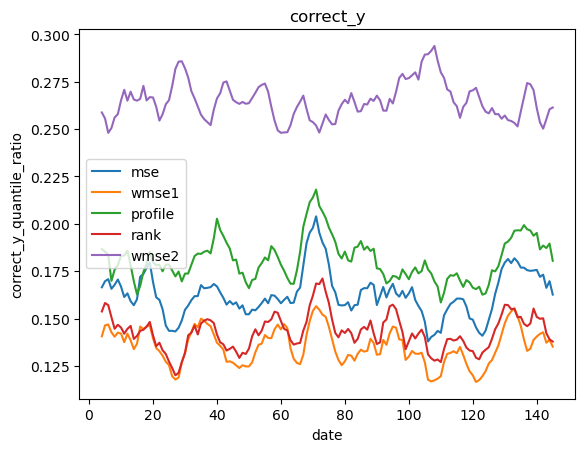

In [48]:
#获取正确quantile的比例
correct_quatile_ratio = dict()
#获取quantile5中mistake quantile的比例
for name,all_files in all_file.items():
    correct_quatile_ratio[name] = []
    for file in all_files:
        correct_quatile_ratio[name].append( get_qantile_ratio(file,5,5))

    y = correct_quatile_ratio[name]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y,label=name)
    #规定label
    plt.xlabel('date')
    plt.ylabel('correct_y_quantile_ratio')
    plt.title('correct_y')
    plt.legend()

plt.show()  

In [49]:
def get_qantile_ratio(df,quantile,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y也为quantile的比例
    quantile_y_true = subset[subset['quantile_y'] == quantile]
    quantile_y_true_ratio = len(quantile_y_true)/len(subset)       

    return quantile_y_true_ratio

def get_mistake_quantile_ratio(df,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中quantile_y为中位数以后的quantiel的比例
    quantile_y_mistake = subset[subset['quantile_y'] <= quantile_num//2]
    quantile_y_mistake_ratio = len(quantile_y_mistake)/len(subset)
    return quantile_y_mistake_ratio

def get_negative_return_ratio(df,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中Y为负的比例
    quantile_y_mistake = subset[subset['Y'] <= 0]
    quantile_y_mistake_ratio = len(quantile_y_mistake)/len(subset)
    return quantile_y_mistake_ratio

def get_positive_return_ratio(df,quantile_num=5):
    df['quantile_y'] = pd.qcut(df['Y'], quantile_num, labels=range(1, quantile_num+1))
    df['quantile_y_hat'] = pd.qcut(df['Y_hat'], quantile_num, labels=range(1, quantile_num+1))
    subset = df[df['quantile_y_hat'] == quantile]
    #查看subset中Y为正的比例
    quantile_y_mistake = subset[subset['Y'] > 0]
    quantile_y_mistake_ratio = len(quantile_y_mistake)/len(subset)
    return quantile_y_mistake_ratio

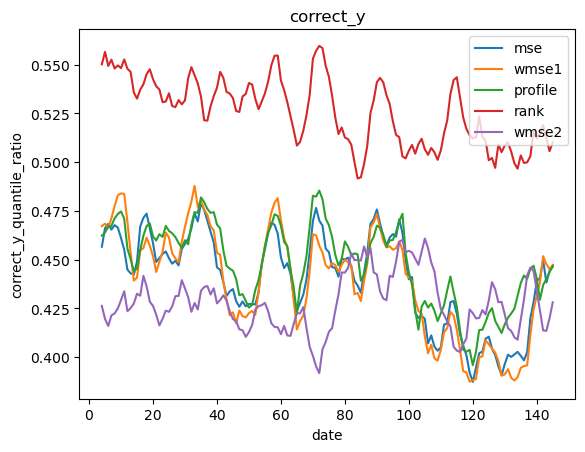

In [50]:
#获取正确quantile的比例
correct_quatile_ratio = dict()
#获取quantile5中mistake quantile的比例
for name,all_files in all_file.items():
    correct_quatile_ratio[name] = []
    for file in all_files:
        correct_quatile_ratio[name].append( get_positive_return_ratio(file))

    y = correct_quatile_ratio[name]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y,label=name)
    #规定label
    plt.xlabel('date')
    plt.ylabel('correct_y_quantile_ratio')
    plt.title('correct_y')
    plt.legend()

plt.show()  

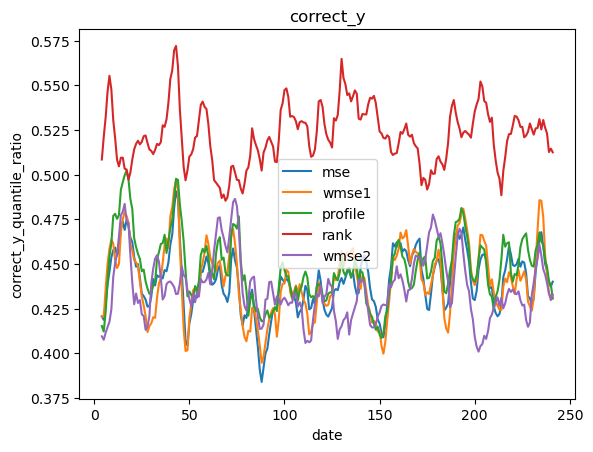

In [53]:
#获取正确quantile的比例
correct_quatile_ratio = dict()
#获取quantile5中mistake quantile的比例
for name,all_files in all_file_test.items():
    correct_quatile_ratio[name] = []
    for file in all_files:
        correct_quatile_ratio[name].append( get_positive_return_ratio(file))

    y = correct_quatile_ratio[name]
    #平滑y，取5天均值，y为list
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y,label=name)
    #规定label
    plt.xlabel('date')
    plt.ylabel('correct_y_quantile_ratio')
    plt.title('correct_y')
    plt.legend()

plt.show()  

In [54]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pdb
import pickle
import gc
import scipy.stats as st

def trim(x, rlow=None, rhigh=None,ratio=None,drop_nan=True): # 0<ratio<0.5
    x1 = x.copy()
    if ratio != None:
        if drop_nan:
            x2 = x1.loc[x1.notna()]
            rlow = np.percentile(x2.values,ratio*100)
            rhigh = np.percentile(x2.values, (1-ratio)*100)
        else:
            print('[ERROR] nan in x values!')
            raise BaseException
    x1[x1<rlow] = rlow
    x1[x1>rhigh] = rhigh
    return x1

def cal_norm(ds):
    ds1 = ds.rank(pct=False,ascending=True,na_option='keep')/(ds.notna().sum()+1)
    ds2 = pd.Series(st.norm().ppf(ds1),index=ds.index)
    return ds2

def calTurnover(flagMat,isSummary=True):
## flag.mat contains 1, -1, NA;
## turnover=1 means we trade 1 (buy 0.5 and sell 0.5) every day;
    flagMat = flagMat.fillna(0)
    posiNum = (flagMat!=0).sum(axis=1)
    
    tradeMat = (flagMat - flagMat.shift(1,axis=0)).abs()
    to = (tradeMat.sum(axis=1)/(posiNum+posiNum.shift(1))*2).fillna(0)
    if isSummary:
        to = '%.3g'%to.mean()
    return to

def draw_pnl(rtn_vec,fig_name = 'backtest'):
    alpha = rtn_vec.mean()*1e4
    sigma = rtn_vec.std()*1e4
    sharpe = alpha/sigma *np.sqrt(252)
    win_rate = (rtn_vec>0).sum()/(rtn_vec.notna().sum())

    dd = (rtn_vec.cumsum() - rtn_vec.cumsum().cummax())
    mdd = dd.min()*1e2
    mdd_date = dd.idxmin()
    
    fig_name = '{0}:alpha={1};sigma={2};sharpe={3};win_rate={4};mdd={5}% on {6}'.format(
            fig_name,'%.2f'%alpha,'%.2f'%sigma,'%.2f'%sharpe,'%.2f'%win_rate,
            '%.2f'%mdd,mdd_date)

    rtn_vec.cumsum().plot(title=fig_name)
    res = pd.Series([alpha,sigma,sharpe,win_rate,mdd,mdd_date],
                        index=['alpha','sigma','sharpe','win_rate','mdd','mdd_date'])
    return res

def plotPNL(rtnMat,posiMat,posiMat_nature='position',costbps=10,figName='backtest',savefigFile=None):
    '''
    posiMat:contains[0,1],no np.nan;
    '''
    ## 1) calculate pnlVec, costVec;
    pnlMat = rtnMat * posiMat
    if posiMat_nature=='position':
        pnlVec = pnlMat.sum(axis=1)/(posiMat==1).sum(axis=1)
        turnoverVec = calTurnover(posiMat,isSummary=False)
    elif posiMat_nature=='weight':
        pnlVec = pnlMat.sum(axis=1)
        turnoverVec = abs( posiMat.fillna(0) - posiMat.fillna(0).shift(1,axis=0)).sum(axis=1)
    else:
        print('[ERROR] wrong posiMat_nature value!')
        return False

    costVec = turnoverVec * costbps * 1e-4
    pnl_afterCostVec = pnlVec - costVec
    
    ## 2) calculate indicators & pnl(DataFrame);
    alpha = pnlVec.mean()*1e4
    alpha2 = pnl_afterCostVec.mean()*1e4
    sigma = pnlVec.std()*1e4
    sharpe = alpha/sigma*np.sqrt(252)
    sharpe2 = pnl_afterCostVec.mean()/pnl_afterCostVec.std()*np.sqrt(252)
    stkNum = posiMat.fillna(0).apply(lambda x: (x!=0).sum(),axis=1).mean()
    turnover = turnoverVec.mean()
    win_rate = (pnl_afterCostVec>0).sum()/(pnl_afterCostVec.notna().sum())

    pnl = pd.DataFrame(pnlVec,columns=['pnl'])
    pnl['cum_pnl'] = pnlVec.cumsum()
    pnl['cost'] = costVec
    pnl['cum_cost'] = costVec.cumsum()
    pnl['pnl_afterCost'] = pnl_afterCostVec
    pnl['cum_pnl_afterCost'] = pnl_afterCostVec.cumsum()
    pnl['drawdown'] = pnl['cum_pnl'] - pnl['cum_pnl'].cummax()
    pnl.reset_index(inplace=True)
    pnl['date'] = pd.to_datetime(pnl['date'])
    pnl.set_index('date',inplace=True)
    
    mdd = pnl['drawdown'].min()*1e2
    mdd_date = pnl['drawdown'].idxmin()

    ## 3) plot PNL: pd.Series.plot() + pd.Series.plot.bar()
    fig = plt.figure(figsize=(10, 6))
    ax1 = fig.add_axes([0,0.4,1,1]) ## 第1个子图；
    pnl['cum_pnl'].plot(color='blue') ##pd.Series.plot()能够自动识别日期类index，并作为xlable;（并且会自动选择合适的采样）
    pnl['cum_pnl_afterCost'].plot(color='red')
    pnl['cum_cost'].plot(color='green')
    ax2 = fig.add_axes([0,0,1,0.25]) ## 第2个子图；
    pnl['drawdown'].plot.bar(color='gray') ##绘制plot.bar时，xlable并不会自动选择合适的采样；

    ax1.grid(True,axis='x',color='green',linestyle=':',linewidth=0.5) ## 绘制辅助线；
    ax2.grid(True,axis='x',color='green',linestyle=':',linewidth=0.5)

    ax2.xaxis.set_visible(False) ##xlable太密集，不显示
    ax1.set_xlabel('')
    thisName = '{0}:alpha={1};sigma={2};sharpe={3};stknum={4};turnover={5};win_rate={6};mdd={7}% on {8}'.format(
        figName,'%.2f'%alpha,'%.2f'%sigma,'%.2f'%sharpe,'%.2f'%stkNum,'%.2f'%turnover,'%.2f'%win_rate,
        '%.2f'%mdd,mdd_date.strftime('%Y%m%d'))
    ax1.set_title(thisName)
    ax1.legend(loc='upper left',labels=['pnl','pnl_afterCost','cost'])
    if savefigFile != None:
        fig.savefig(savefigFile,dpi=100,bbox_inches='tight')
    res = pd.Series([alpha,sigma,sharpe,alpha2,sharpe2,stkNum,turnover,win_rate,mdd,mdd_date.strftime('%Y%m%d')],
                    index=['alpha','sigma','sharpe','alpha2','sharpe2','stkNum','turnover','win_rate','mdd','mdd_date'])
#     plt.clf()
#     plt.close(fig)
    return {'pnl':pnl,'pnl_summary':res}

def cal_topPNL(yestData,enterRatio=0.8,exitRatio=0.8,year='all',costbps=10,savefigFile=None):    
    if (not all([x in yestData.columns for x in ['date','code','yest','y']])):
        print("[ERROR] yestData's format is wrong!")
        return False
    d1 = yestData.loc[:,['date','code','yest','y']]
    
    #pdb.set_trace()
    ## 1) calculate yestRank & posi;
    d1['yestRank'] = d1.groupby('date')['yest'].rank(method='average',na_option='keep',ascending=True,pct=True)
    
    ## 2) rtnMat & posiMat;
    rtnMat = pd.pivot_table(data=d1,index='date',columns='code',values='y',dropna=False)
    yestRankMat = pd.pivot_table(data=d1,index='date',columns='code',values='yestRank',dropna=False)
    posiMat = pd.DataFrame(np.full(yestRankMat.shape,fill_value=np.nan),index=yestRankMat.index,columns=yestRankMat.columns)
    posiMat[yestRankMat>enterRatio] = 1
    posiMat[yestRankMat<exitRatio] = 0
    posiMat = posiMat.fillna(method='ffill',axis=0).fillna(0)
    posiMat[yestRankMat.isna()] = np.nan
    
    ## 3) result
    if (year=='all'):
        res = plotPNL(rtnMat,posiMat,costbps=costbps,figName=year,savefigFile=savefigFile)
        res['pnl_summary'] = res['pnl_summary'].to_frame(name='all').T
    elif(year=='each'):
        all_year = rtnMat.index.str.slice(0,4).unique()
        pnl_list = []
        pnl_sum_dict = {}
        for tmp_year in all_year:
            tmp_posiMat = posiMat.loc[posiMat.index.str.slice(0,4)==tmp_year,:]
            tmp_rtnMat = rtnMat.loc[rtnMat.index.str.slice(0,4)==tmp_year,:]
            tmp = plotPNL(tmp_rtnMat,tmp_posiMat,costbps=costbps,figName=tmp_year,savefigFile=savefigFile)
            pnl_list.append(tmp['pnl'])
            pnl_sum_dict[tmp_year] = tmp['pnl_summary']
        res = {}
        res['pnl'] = pd.concat(pnl_list,axis=0)
        res['pnl_summary'] = pd.DataFrame(pnl_sum_dict).T
    else:
        tmp_posiMat = posiMat.loc[posiMat.index.str.slice(0,4)==year,:]
        tmp_rtnMat = rtnMat.loc[rtnMat.index.str.slice(0,4)==year,:]
        res = plotPNL(tmp_rtnMat,tmp_posiMat,costbps=costbps,figName=year,savefigFile=savefigFile)
        res['pnl_summary'] = res['pnl_summary'].to_frame(name='all').T
    return(res)

def cal_topPNL2(yestData,ud_field='ud_limit',enterRatio=0.8,exitRatio=0.8,year='all',costbps=10,savefigFile=None):
    ## no buy if up_limit && no sell if down_limit;
    if (not all([x in yestData.columns for x in ['date','code','yest','y']])):
        print("[ERROR] yestData's format is wrong!")
        return False
    d1 = yestData.copy()

    ## 1) calculate yestRank;
    d1['yestRank'] = d1.groupby('date')['yest'].rank(method='average',na_option='keep',ascending=True,pct=True)
    rtnMat = pd.pivot_table(data=d1,index='date',columns='code',values='y',dropna=False)
    yestMat = pd.pivot_table(data=d1,index='date',columns='code',values='yest',dropna=False)
    yestRankMat = pd.pivot_table(data=d1,index='date',columns='code',values='yestRank',dropna=False).fillna(0)
    posiMat = pd.DataFrame(np.full(yestRankMat.shape,fill_value=0),index=yestRankMat.index,columns=yestRankMat.columns)
    ud_limitMat = pd.pivot_table(data=d1,index='date',columns='code',values=ud_field,dropna=False).fillna(0)

    ## 2) calPosiMat： ## no buy if up_limit && no sell if down_limit;
    for i,row_index in enumerate(posiMat.index):
        if (i==0):
            continue
        flag1 = (yestRankMat.iloc[i,:]>enterRatio)
        flag2 = (posiMat.iloc[i-1,:]==0) & (ud_limitMat.iloc[i,:]==1)
        posiMat.loc[row_index,(~flag2 & flag1)] = 1

        flag3 = (yestRankMat.iloc[i,:]>exitRatio) & (yestRankMat.iloc[i,:]<=enterRatio)
        flag4 = (posiMat.iloc[i-1,:]==1)
        posiMat.loc[row_index,(flag3 & flag4)] = 1

        flag5 = (posiMat.iloc[i-1,:]==1) & (posiMat.iloc[i,:]==0) & (ud_limitMat.iloc[i,:]==-1)
        posiMat.loc[row_index,flag5] = 1
        
        if (i== (posiMat.shape[0]-1)):## position=0 if yest=NA on last day;
            flag6 = yestMat.iloc[i,:].isna()
            posiMat.loc[row_index,flag6] = 0
        
    #pdb.set_trace()
    ## 3) result
    if (year=='all'):
        res = plotPNL(rtnMat,posiMat,costbps=costbps,figName=year,savefigFile=savefigFile)
        res['pnl_summary'] = res['pnl_summary'].to_frame(name='all').T
    elif(year=='each'):
        all_year = rtnMat.index.str.slice(0,4).unique()
        pnl_list = []
        pnl_sum_dict = {}
        for tmp_year in all_year:
            tmp_posiMat = posiMat.loc[posiMat.index.str.slice(0,4)==tmp_year,:]
            tmp_rtnMat = rtnMat.loc[rtnMat.index.str.slice(0,4)==tmp_year,:]
            tmp = plotPNL(tmp_rtnMat,tmp_posiMat,costbps=costbps,figName=tmp_year,savefigFile=savefigFile)
            pnl_list.append(tmp['pnl'])
            pnl_sum_dict[tmp_year] = tmp['pnl_summary']
        res = {}
        res['pnl'] = pd.concat(pnl_list,axis=0)
        res['pnl_summary'] = pd.DataFrame(pnl_sum_dict).T
    else:
        tmp_posiMat = posiMat.loc[posiMat.index.str.slice(0,4)==year,:]
        tmp_rtnMat = rtnMat.loc[rtnMat.index.str.slice(0,4)==year,:]
        res = plotPNL(tmp_rtnMat,tmp_posiMat,costbps=costbps,figName=year,savefigFile=savefigFile)
        res['pnl_summary'] = res['pnl_summary'].to_frame(name='all').T
    return(res)

def cal_posPNL(yestData,y_type='y5'):## calculate positive weight pnl;
    def _cal_posPNL(df):
        df['yest_norm'] = cal_norm(df['yest'])
        df['flag'] = (df['yest_norm']>0) & (df['ud_limit_h2']!=1)
        res = (df[y_type] * df['yest_norm'] * df['flag']).sum()/(df['yest_norm'] * df['flag']).sum()
        return res
    
    pnl = yestData.groupby('date').apply(_cal_posPNL)
    alpha = pnl.mean()*1e4
    sigma = pnl.std()*1e4
    sharpe = alpha/sigma*np.sqrt(252)
    pnl_summary = pd.Series([alpha,sigma,sharpe,],index=['alpha','sigma','sharpe',])
    return {'pnl':pnl,'pnl_summary':pnl_summary}

def cal_scorecard(df,y_type = 'y5',method = 'pearson'):
    ic = df.groupby('date')[['yest',y_type]].apply(lambda x:x.corr(method=method).iloc[0,1])
    ic_mean = ic.mean()
    ic_std = ic.std()
    icir = ic_mean/ic_std*pow(250,0.5)
    return {'ic':ic,'ic_mean':ic_mean,'icir':icir}

def cal_multiPNL(yestData):
    top_pnl = cal_topPNL(yestData,enterRatio=0.95,exitRatio=0.85,year='all',costbps=10,savefigFile=None)
    top_pnl2 = cal_topPNL2(yestData,ud_field='ud_limit_h2',enterRatio=0.9,exitRatio=0.9,year='all',costbps=10,savefigFile=None)  #
    pos_pnl = cal_posPNL(yestData,y_type='y5')
    ic_test = yestData[['date','y5','yest']].set_index('date')
    res_indicator = cal_scorecard(ic_test,y_type = 'y5',method = 'pearson')
    res_all = {'res_indicator':res_indicator,'top_pnl':top_pnl,'top_pnl2':top_pnl2,'pos_pnl':pos_pnl}
    return res_all

def simple_ols(yestData, yest1='yest_benchmark', yest2='yest_pool', weight1=0.4):
    yest_norm = yestData.groupby('date')[[yest1, yest2]].apply(lambda x: (x - x.mean()) / x.std())
    weight2 = 1 - weight1
    yest = weight1 * yest_norm[yest1] + weight2 * yest_norm[yest2]
    return yest
    
def cal_margin(m_old,m_new):
    s01 = m_old['top_pnl2']['pnl_summary'].loc['all',['alpha','sharpe2']]
    s02 = m_old['pos_pnl']['pnl_summary'][['alpha','sharpe']]
    m0 = s01.append(s02)
    s11 = m_new['top_pnl2']['pnl_summary'].loc['all',['alpha','sharpe2']]
    s12 = m_new['pos_pnl']['pnl_summary'][['alpha','sharpe']]
    m1 = s11.append(s12)
    margin_top = (s11/s01).sum()/2
    margin_pos = (s12/s02).sum()/2
    margin = (m1/m0).sum()/4
    return pd.Series({'margin_top':margin_top,'margin_pos':margin_pos,'margin':margin})

In [55]:
all_files = [pd.read_csv(f'/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid/{f}',
                         dtype={'date':str})for f in sorted(os.listdir('/home/laiminzhi/reconfiguration_code/predict_data/y3_label_rank_all_normal_no_ud_limit_h2/selected_feature(all)_loss(combine)_depth4_sizes(249_128_128_1)_bd_valid'))]

<ipython-input-54-98c2da85d691>:147: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  posiMat = posiMat.fillna(method='ffill',axis=0).fillna(0)


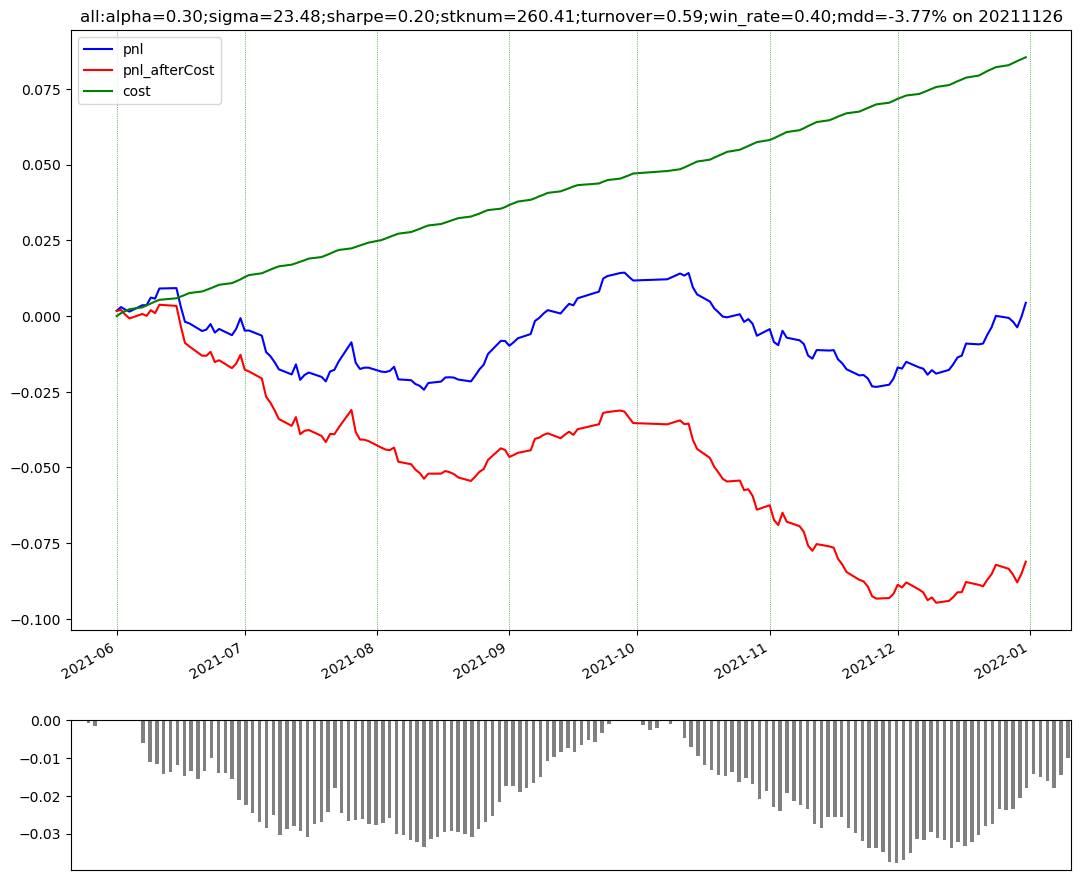

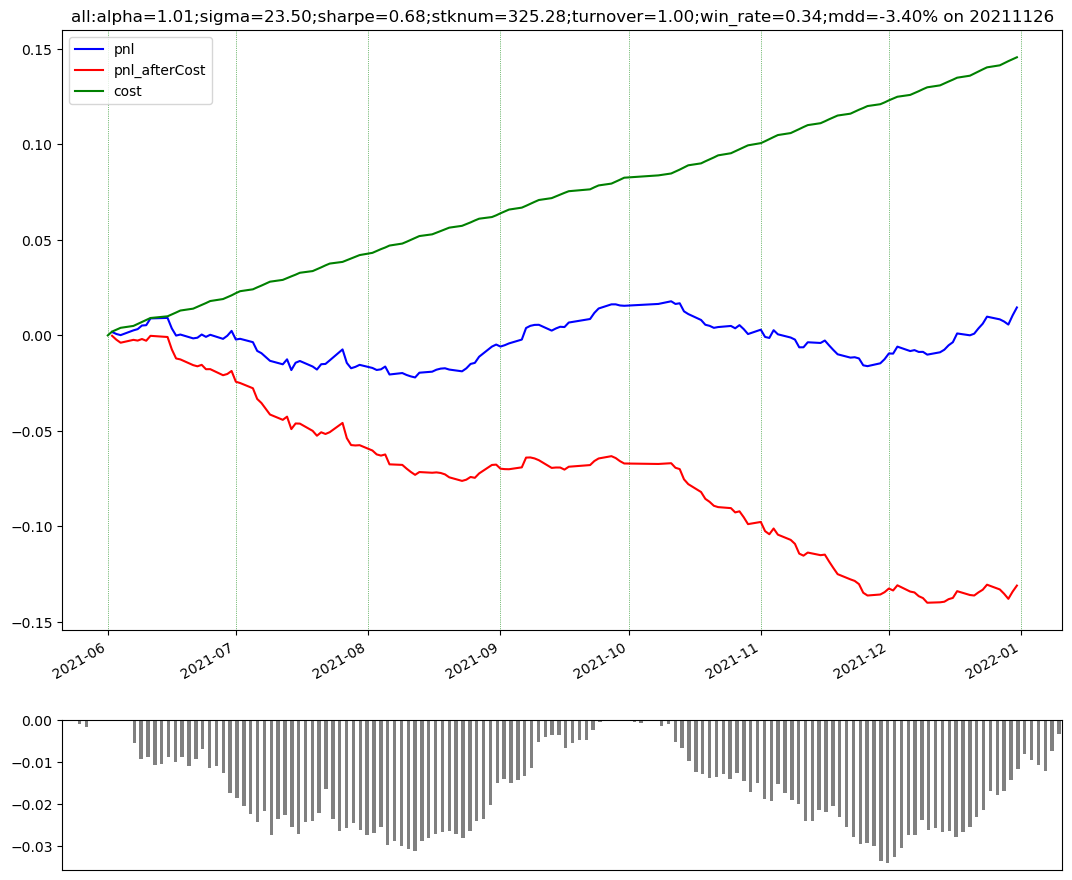

In [56]:
yest = pd.concat(all_files, axis=0)
xy = pd.read_hdf('/home/laiminzhi/wenbin/DL_stock_combo/data/xy_data/xy_data.h5').reset_index()
universe = 'univ_tradable'

xy = xy.loc[xy[universe]==1,:'ud_limit_h4']
xy = xy.rename(columns={'y1':'y'})
xy = pd.merge(xy, yest,on=['date','code'],how='inner')

##---- 1. benchmark ----##
xy['yest'] = xy['Y_hat']
m_pool = cal_multiPNL(xy)
#xy['yest'] = xy['Y']
#m_baseline = cal_multiPNL(xy)
#xy['yest_old'] = simple_ols(xy, yest1='yest_baseline', yest2='yest_pool', weight1=0.4)
#xy['yest'] = xy['yest_old']
#m_old = cal_multiPNL(xy)

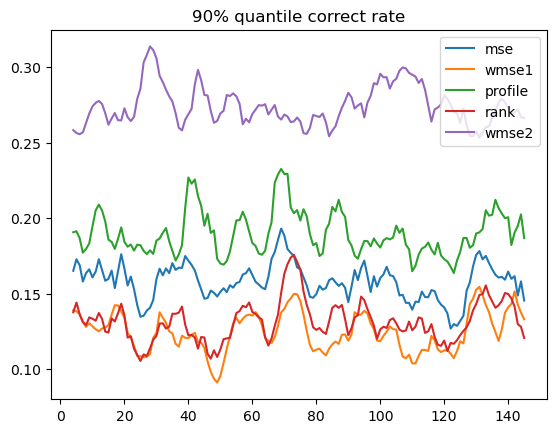

In [72]:
#查看all_files_rank中y_hat前10%的股票的y的quantile和y_hat的quantile的关系
correct_rate = dict()
for name,all_files in all_file.items():
    correct_rate[name] = []
    for file in all_files:
        x = file
        x['quantile_y'] = pd.qcut(file['Y'], 5, labels=range(1, 6))
        x['quantile_y_hat'] = pd.qcut(file['Y_hat'], 5, labels=range(1, 6))
        #x选出y_hat前10%的股票
        x = file[file['Y_hat'] >= file['Y_hat'].quantile(0.9)]
        #给x中的每个股票标记y_hat的quantile和y的quantile
        subset = x[x['quantile_y_hat'] == quantile]
        #查看subset中quantile_y也为quantile的比例
        quantile_y_true = subset[subset['quantile_y'] == 5]
        quantile_y_true_ratio = len(quantile_y_true)/len(subset) 
        correct_rate[name].append(quantile_y_true_ratio)

    y = correct_rate[name]
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y,label=name)
    plt.legend()
    plt.title("90% quantile correct rate")

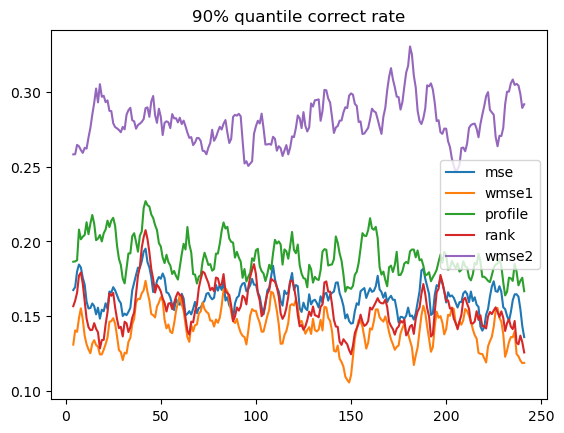

In [73]:
#查看all_files_rank中y_hat前10%的股票的y的quantile和y_hat的quantile的关系
correct_rate = dict()
for name,all_files in all_file_test.items():
    correct_rate[name] = []
    for file in all_files:
        x = file
        x['quantile_y'] = pd.qcut(file['Y'], 5, labels=range(1, 6))
        x['quantile_y_hat'] = pd.qcut(file['Y_hat'], 5, labels=range(1, 6))
        #x选出y_hat前10%的股票
        x = file[file['Y_hat'] >= file['Y_hat'].quantile(0.9)]
        #给x中的每个股票标记y_hat的quantile和y的quantile
        subset = x[x['quantile_y_hat'] == quantile]
        #查看subset中quantile_y也为quantile的比例
        quantile_y_true = subset[subset['quantile_y'] == 5]
        quantile_y_true_ratio = len(quantile_y_true)/len(subset) 
        correct_rate[name].append(quantile_y_true_ratio)

    y = correct_rate[name]
    y = pd.Series(y).rolling(5).mean().to_list()
    x = range(len(y))
    plt.plot(x,y,label=name)
    plt.legend()
    plt.title("90% quantile correct rate")

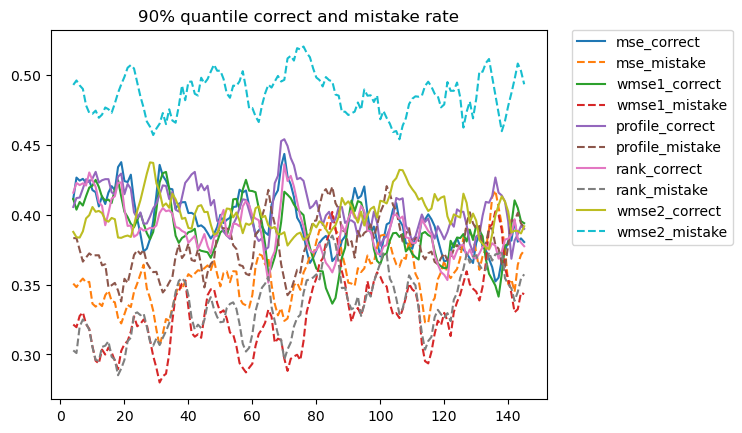

In [78]:
#把correct rate和错误rate画在一张图上
all_rate = dict()
for name,all_files in all_file.items():
    correct_name = name+'_correct'
    mistake_name = name+'_mistake'
    all_rate[correct_name] = []
    all_rate[mistake_name] = []
    for file in all_files:
        x=file
        x['quantile_y'] = pd.qcut(file['Y'], 5, labels=range(1, 6))
        x['quantile_y_hat'] = pd.qcut(file['Y_hat'], 5, labels=range(1, 6))
        #x选出y_hat前10%的股票
        x = file[file['Y_hat'] >= file['Y_hat'].quantile(0.9)]
        subset=x
        #查看subset中quantile_y也为quantile的比例
        quantile_y_true = subset[subset['quantile_y'] > 3]
        quantile_y_true_ratio = len(quantile_y_true)/len(subset)
        all_rate[correct_name].append(quantile_y_true_ratio)

        #查看subset中quantile_y为中位数以后的quantiel的比例
        quantile_y_mistake = subset[subset['quantile_y'] < 3]
        quantile_y_mistake_ratio = len(quantile_y_mistake)/len(subset)
        all_rate[mistake_name].append(quantile_y_mistake_ratio)

    y1 = all_rate[correct_name]
    y2 = all_rate[mistake_name]
    y1 = pd.Series(y1).rolling(5).mean().to_list()
    y2 = pd.Series(y2).rolling(5).mean().to_list()
    x = range(len(y1))
    plt.plot(x,y1,label=correct_name)
    #画虚线
    plt.plot(x,y2,label=mistake_name,linestyle='--')
    #把ldegend放到图外面
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.title("90% quantile correct and mistake rate")

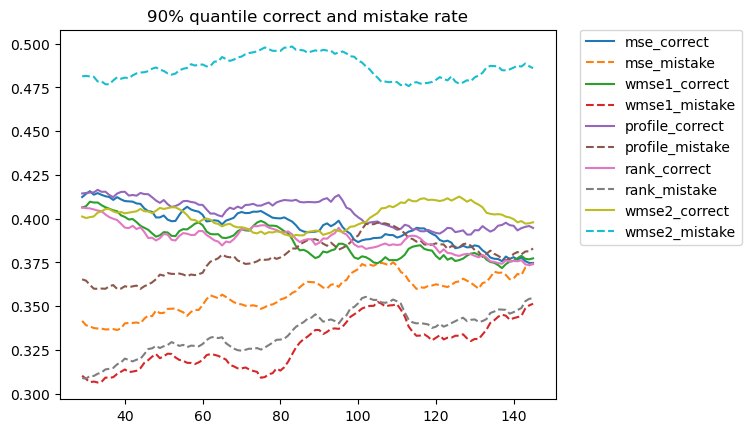

In [79]:
#把correct rate和错误rate画在一张图上
all_rate = dict()
for name,all_files in all_file.items():
    correct_name = name+'_correct'
    mistake_name = name+'_mistake'
    all_rate[correct_name] = []
    all_rate[mistake_name] = []
    for file in all_files:
        x=file
        x['quantile_y'] = pd.qcut(file['Y'], 5, labels=range(1, 6))
        x['quantile_y_hat'] = pd.qcut(file['Y_hat'], 5, labels=range(1, 6))
        #x选出y_hat前10%的股票
        x = file[file['Y_hat'] >= file['Y_hat'].quantile(0.9)]
        subset=x
        #查看subset中quantile_y也为quantile的比例
        quantile_y_true = subset[subset['quantile_y'] > 3]
        quantile_y_true_ratio = len(quantile_y_true)/len(subset)
        all_rate[correct_name].append(quantile_y_true_ratio)

        #查看subset中quantile_y为中位数以后的quantiel的比例
        quantile_y_mistake = subset[subset['quantile_y'] < 3]
        quantile_y_mistake_ratio = len(quantile_y_mistake)/len(subset)
        all_rate[mistake_name].append(quantile_y_mistake_ratio)

    y1 = all_rate[correct_name]
    y2 = all_rate[mistake_name]
    y1 = pd.Series(y1).rolling(30).mean().to_list()
    y2 = pd.Series(y2).rolling(30).mean().to_list()
    x = range(len(y1))
    plt.plot(x,y1,label=correct_name)
    #画虚线
    plt.plot(x,y2,label=mistake_name,linestyle='--')
    #把ldegend放到图外面
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.title("90% quantile correct and mistake rate")

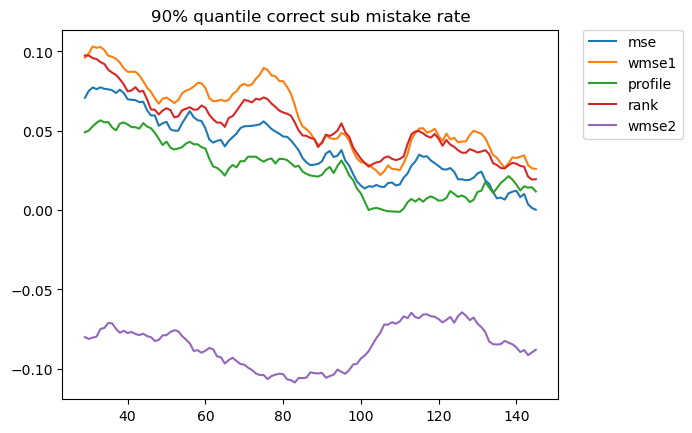

In [82]:
#画出预测正确-预测错误的比例
all_rate = dict()
for name,all_files in all_file.items():
    correct_name = name+'_correct'
    mistake_name = name+'_mistake'
    all_rate[correct_name] = []
    all_rate[mistake_name] = []
    for file in all_files:
        x=file
        x['quantile_y'] = pd.qcut(file['Y'], 5, labels=range(1, 6))
        x['quantile_y_hat'] = pd.qcut(file['Y_hat'], 5, labels=range(1, 6))
        #x选出y_hat前10%的股票
        x = file[file['Y_hat'] >= file['Y_hat'].quantile(0.9)]
        subset=x
        #查看subset中quantile_y也为quantile的比例
        quantile_y_true = subset[subset['quantile_y'] > 3]
        quantile_y_true_ratio = len(quantile_y_true)/len(subset)
        all_rate[correct_name].append(quantile_y_true_ratio)

        #查看subset中quantile_y为中位数以后的quantiel的比例
        quantile_y_mistake = subset[subset['quantile_y'] < 3]
        quantile_y_mistake_ratio = len(quantile_y_mistake)/len(subset)
        all_rate[mistake_name].append(quantile_y_mistake_ratio)

    y1 = all_rate[correct_name]
    y2 = all_rate[mistake_name]
    y1 = pd.Series(y1).rolling(30).mean()
    y2 = pd.Series(y2).rolling(30).mean()
    x = range(len(y1))
    plt.plot(x,(y1-y2).to_list(),label=name)
    #把ldegend放到图外面
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.title("90% quantile correct sub mistake rate")

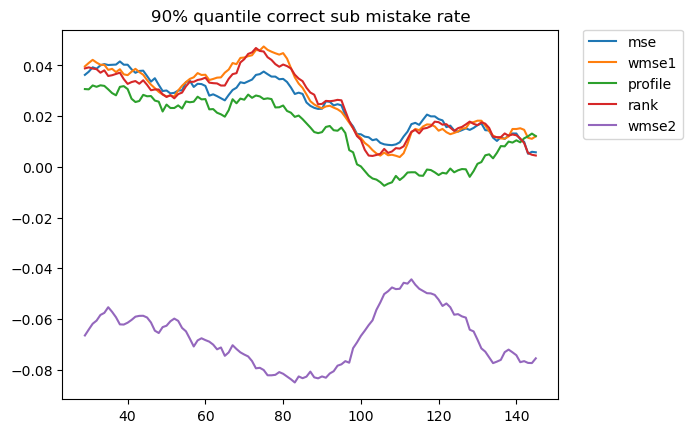

In [85]:
#画出预测正确-预测错误的比例
all_rate = dict()
for name,all_files in all_file.items():
    correct_name = name+'_correct'
    mistake_name = name+'_mistake'
    all_rate[correct_name] = []
    all_rate[mistake_name] = []
    for file in all_files:
        x=file
        x['quantile_y'] = pd.qcut(file['Y'], 5, labels=range(1, 6))
        x['quantile_y_hat'] = pd.qcut(file['Y_hat'], 5, labels=range(1, 6))
        #x选出y_hat前10%的股票
        x = file[file['Y_hat'] >= file['Y_hat'].quantile(0.9)]
        subset=x
        #查看subset中quantile_y也为quantile的比例
        quantile_y_true = subset[subset['quantile_y'] ==5 ]
        quantile_y_true_ratio = len(quantile_y_true)/len(subset)
        all_rate[correct_name].append(quantile_y_true_ratio)

        #查看subset中quantile_y为中位数以后的quantiel的比例
        quantile_y_mistake = subset[subset['quantile_y'] ==1]
        quantile_y_mistake_ratio = len(quantile_y_mistake)/len(subset)
        all_rate[mistake_name].append(quantile_y_mistake_ratio)

    y1 = all_rate[correct_name]
    y2 = all_rate[mistake_name]
    y1 = pd.Series(y1).rolling(30).mean()
    y2 = pd.Series(y2).rolling(30).mean()
    x = range(len(y1))
    plt.plot(x,(y1-y2).to_list(),label=name)
    #把ldegend放到图外面
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)

    plt.title("90% quantile correct sub mistake rate")